## Which minima are preferred by which optimizers?
#### Project for OptML course at EPFL

When training a neural net, the resulting stationary point $\nabla f(x)=0$ depends on many things like initialization, optimization algorithm, batch size, learning rate and others. It was hypothesized in 1997 [1] that not all minima of a neural network are the same when it comes to generalization capabilities. In particular it was conjectured that the more a minimum is *flat*, meaning that Hessian $\frac{\partial f}{\partial \theta^2}$ eigenvalues are small, the better network generalizes. The reasoning is that a more flat minimum means that parameter perturbation would not change (spoil) the loss a lot.

The problem with this approach was pointed out in [2]. It was shown that a fixed network can be reparametrized such that it has arbitrary sharpness. Therefore the function represented is the same (and having same generalization capabilities) but sharpness would be different.

Current research focuses on trying to quantify sharpness in another form. For example, paper [4] visualizes the loss landscape in two random directions and proposes to normalize the weights. In [3] another idea is considered: cosine similarity between gradients on different batches is considered as a new generalization metric.

The paper [5] uses another normalized sharpness metric and shows that it correlates with generalization gap well. PAC-Bayesian approach tries to quantify the difference between test and train errors using KL divergence between these distributions. The paper uses a mix between Hessian diagonal values and weight matrix norms.

Paper [6] tackles the problem by estimating Hessian spectral density empirically using techniques allowing for computational feasibility for large networks.

Paper [7] proposes another scale-invariant generalization metric.

We note that the papers usually study the effect of different batch sizes on the generalization properties. In this project we compare the effect of **optimizer** on the sharpness metrics as well as on generalization properties.

We propose to use the following datsets for our experiment:
1. Fisher's Iris dataset (150 objects, 5 features, 3 classes)
2. Boston Housing dataset (~500 objects, 15 features, regression)
3. MNIST dataset (70000 objects, 28x28 features, 10 classes)

We will use the following [optimizers](https://keras.io/optimizers/):
1. (S)GD
2. SGD with momentum
3. AdaDelta

And will vary the following parameters:
1. Batch size
2. Learning rate
3. [Initialization](https://keras.io/initializers/) (Normal, Uniform, Orthogonal, LeCun, Glorot)

We plan to measure the following metrics:
1. Empirical generalization gap
2. Hessian spectrum
3. Proposed metric from [3]
4. Proposed metric from [4]
5. Proposed metric from [5]
6. Proposed metric from [7]

Our main contribution would be to **measure the effect of optimizer on minima quality**

[1] Hochreiter, Sepp and Schmidhuber, Jürgen. [Flat minima](http://www.bioinf.jku.at/publications/older/3304.pdf). Neural Computation, 9(1):1–42, 1997.

[2] Dinh, Laurent, et al. [Sharp minima can generalize for deep nets](https://arxiv.org/pdf/1703.04933.pdf). Proceedings of ICML-Volume 70. JMLR. org, 2017.

[3] [The Generalization Mystery: Sharp vs Flat Minima](https://www.inference.vc/sharp-vs-flat-minima-are-still-a-mystery-to-me/)

[4] Li H, Xu Z, Taylor G, Studer C, Goldstein T. [Visualizing the loss landscape of neural nets](https://papers.nips.cc/paper/7875-visualizing-the-loss-landscape-of-neural-nets.pdf). In NeurIPS 2018 (pp. 6391-6401).

[5] Tsuzuku Y, Sato I, Sugiyama M. [Normalized Flat Minima: Exploring Scale Invariant Definition of Flat Minima for Neural Networks using PAC-Bayesian Analysis](https://arxiv.org/pdf/1901.04653.pdf). arXiv preprint arXiv:1901.04653. 2019 Jan 15.

[6] Ghorbani B, Krishnan S, Xiao Y. [An Investigation into Neural Net Optimization via Hessian Eigenvalue Density](https://arxiv.org/pdf/1901.10159.pdf). arXiv preprint arXiv:1901.10159. 2019 Jan 29.

[7] Rangamani A, Nguyen NH, Kumar A, Phan D, Chin SH, Tran TD. [A Scale Invariant Flatness Measure for Deep Network Minima](https://arxiv.org/pdf/1902.02434.pdf). arXiv preprint arXiv:1902.02434. 2019 Feb 6.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
from IPython.display import clear_output

In [2]:
# for environ
import os

# only using device 0
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# importing tensorflow
import tensorflow as tf

# import scipy
import scipy, csv

In [3]:
!rm iris.csv
!wget https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv

--2019-03-07 23:02:07--  https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.112.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.112.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3858 (3.8K) [text/plain]
Saving to: ‘iris.csv’

iris.csv            100%[===================>]   3.77K  --.-KB/s    in 0s      

2019-03-07 23:02:07 (111 MB/s) - ‘iris.csv’ saved [3858/3858]



Using feedforward fully-connected neural network with input size 28^2, 5 layers (28^2-40-40-30-30-10-1), 10-dim output (classification). Using MNIST as data. Using optimizers: SGD, Adam. Plotting spectra of the hessian after convergence. Using 10 repetitions of the experiment.

In [546]:
# loading mnist
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """Entry point for launching an IPython kernel.


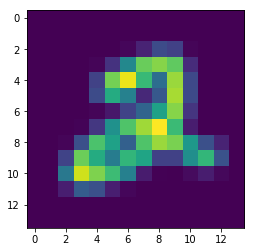

In [558]:
plt.imshow(scipy.misc.imresize(x_train[5], (14, 14)))

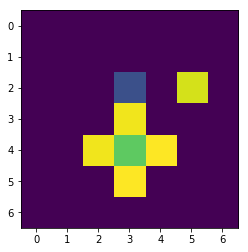

In [543]:
plt.imshow(x_train[9])

In [3]:
tf.reset_default_graph()
# allowing GPU memory growth to allocate only what we need
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
sess = tf.Session(config=config, graph = tf.get_default_graph())

In [4]:
iris = list(csv.reader(open('iris.csv')))[1:]

# The inputs are four floats: sepal length, sepal width, petal length, petal width.
inputs  = np.array(iris)[:,:4].astype(np.float)

In [5]:
outputs = np.array(iris)[:,4]
# Convert the output strings to ints.
outputs_vals, outputs_ints = np.unique(outputs, return_inverse=True)

In [6]:
# Split the input and output data sets into training and test subsets.
inds = np.random.permutation(len(inputs))
train_inds, test_inds = np.array_split(inds, 2)
x_train, y_train = inputs[train_inds], outputs_ints[train_inds]
x_test,  y_test  = inputs[test_inds],  outputs_ints[test_inds]

In [7]:
# input data: batch w h channels
x = tf.placeholder(tf.float32, shape = (None, 4), name = 'input')

# output labels (vector)
y = tf.placeholder(tf.int64, shape = (None,), name = 'labels')

# one-hot encoded labels
y_one_hot = tf.one_hot(y, 3)

In [8]:
def fc_layer(x, n, activation = tf.nn.sigmoid):
    """ Fully connected layer for input x and output dim n """
    return tf.contrib.layers.fully_connected(x, n, activation_fn=activation,
    weights_initializer=tf.initializers.lecun_normal(), weights_regularizer=None,
    biases_initializer=tf.zeros_initializer(), biases_regularizer=None, trainable=True)

In [9]:
# flatten w * h
l0 = tf.contrib.layers.flatten(x)

# layers
with tf.name_scope('layers'):
    z = l0
    z = fc_layer(z, 10)
    z = fc_layer(z, 5)
    z = fc_layer(z, 3, activation = None)
    output = z

# softmax to make probability distribution
logits = tf.nn.softmax(output)

# predicted labels
labels = tf.argmax(logits, axis = 1)

# loss: cross-entropy
loss = tf.losses.softmax_cross_entropy(y_one_hot, logits)

# accuracy of predictions
accuracy = tf.contrib.metrics.accuracy(labels, y)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [10]:
# list of all parameters
params = tf.trainable_variables()#tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)

In [11]:
print('Total parameters:', np.sum([np.prod(p.shape) for p in params]))

Total parameters: 123


In [12]:
class OwnGradientDescent():
    def __init__(self, gamma = 0.5, theta = 0.9):
        # gamma (learning rate)
        self.gamma = tf.Variable(gamma, dtype = tf.float32)
        self.theta = theta
        
    def minimize(self, loss, params):
        """ Minimize some loss """
        def decrement_weights(W, gamma, grads):
            """ w = w - how_much """
            ops = [w.assign(tf.subtract(w, tf.multiply(gamma, grad))) for w, grad in zip(W, grads)]
            return tf.group(ops)
        
        # gradients of the loss w.r.t. params
        grads = tf.gradients(loss, params)
        
        # perform gradient descent step
        train_op = decrement_weights(params, self.gamma, grads)
        
        # updating gamma
        upd_op = self.gamma.assign(tf.multiply(self.gamma, self.theta))
        
        return tf.group(train_op, upd_op)

In [13]:
def epoch(train_op):
    # do the training
    train_loss, train_acc, _ = sess.run([loss, accuracy, train_op], feed_dict = {x: x_train, y: y_train})

    # compute accuracy and loss
    test_loss, test_acc = sess.run([loss, accuracy], feed_dict = {x: x_test, y: y_test})

    # saving data
    metrics['train_loss'] += [train_loss]
    metrics['test_loss'] += [test_loss]
    metrics['train_acc'] += [train_acc]
    metrics['test_acc'] += [test_acc]

In [14]:
def dz_dw_flatten(z):
    """ Calculate dz/dparams and flatten the result """
    return tf.concat([tf.reshape(x, shape = (-1,)) for x in tf.gradients(z, params)], axis = 0)

In [15]:
def iterate_flatten(tensor):
    """ Iterate over flattened items of a tensor """
    if type(tensor) == list:
        for t in tensor:
            for v in iterate_flatten(t):
                yield v
    elif len(tensor.shape) == 0:
        yield tensor
    else:
        for idx in range(tensor.shape[0]):
            for v in iterate_flatten(tensor[idx]):
                yield v

In [16]:
# gradients of the loss w.r.t. params
grads = tf.gradients(loss, params)
grad_components = list(iterate_flatten(grads))
hessian = [dz_dw_flatten(t) for t in tqdm(grad_components)]

  0%|          | 0/123 [00:00<?, ?it/s]

Instructions for updating:
Use tf.cast instead.


100%|██████████| 123/123 [00:09<00:00, 10.53it/s]


In [17]:
metrics = {}
def train_and_get_hessian(operation, epochs_):
    # metrics to compute
    global metrics
    metrics = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': []}
    
    # initializing weights...
    init = tf.global_variables_initializer()
    sess.run(init)
    
    for i in tqdm(range(epochs_)):
        epoch(operation)
    
    clear_output()
    
    plt.figure()
    plt.plot(metrics['train_loss'], label = 'train_loss')
    plt.plot(metrics['test_loss'], label = 'test_loss')
    #plt.legend()
    #plt.show()

    #plt.figure()
    plt.plot(metrics['train_acc'], label = 'train_acc')
    plt.plot(metrics['test_acc'], label = 'test_acc')
    plt.legend()
    plt.show()
    
    H = sess.run(hessian, feed_dict = {x: x_train, y: y_train})
    eigens = np.real(np.linalg.eig(H)[0])
    return metrics['train_acc'][-1], metrics['test_acc'][-1], eigens

In [18]:
def experiment_for_optimizer(gd, epochs = 1000, accuracy_threshold = 0.9, repetitions = 20):
    """ Train repetitions copies of a network with optimizer, output
    Hessian eigenvalues of those satisfying accuracy threshold"""

    result = []
    r = 0
    while r < repetitions:
        train_acc, test_acc, eigens = train_and_get_hessian(gd, epochs)
        if train_acc < accuracy_threshold or test_acc < accuracy_threshold:
            print('Error: accuracy is insufficient opt=%s train=%.2f test=%.2f' % (str(gd), train_acc, test_acc))
            print('Done: %d/%d' % (r, repetitions))
            continue
        r += 1
        print('Done: %d/%d' % (r, repetitions))
        result += list(eigens)
    return result

100%|██████████| 1000/1000 [00:01<00:00, 894.66it/s]


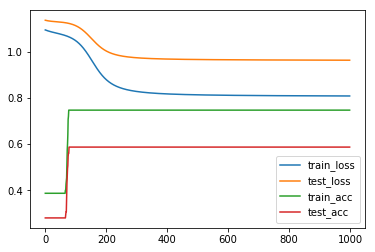

In [30]:
train_acc, test_acc, eigens = train_and_get_hessian(gd, 1000)

## Experiments for Adam and GD, measuring spectrum of Hessian

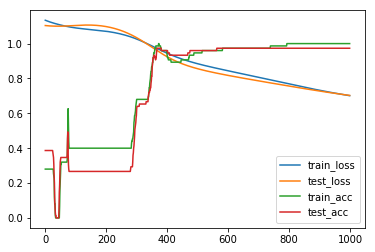

Done: 20/20


In [19]:
adam = tf.train.AdamOptimizer().minimize(loss)
eig_adam = experiment_for_optimizer(adam, epochs = 1000, accuracy_threshold = 0.9, repetitions = 20)

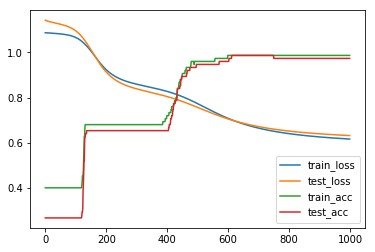

Done: 20/20


In [24]:
gd = OwnGradientDescent(gamma = 0.5, theta = 0.999).minimize(loss, params)
eig_gd = experiment_for_optimizer(gd, epochs = 1000, accuracy_threshold = 0.9, repetitions = 20)

In [25]:
def hist_th(eigens, threshold = 100, name = 'GD'):
    plt.hist(np.extract(np.abs(eigens) < threshold, np.abs(eigens)), label = name, alpha = 0.5)
    #plt.show()

In [26]:
def plot_for_thr(threshold = 100):
    plt.figure()
    hist_th(eig_gd, threshold, 'GD')
    hist_th(eig_adam, threshold, 'Adam')
    plt.legend()

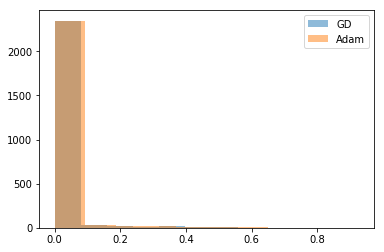

In [27]:
plot_for_thr(1)

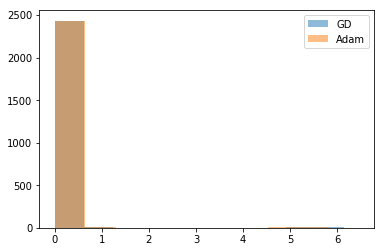

In [28]:
plot_for_thr(100)

Spectra are similar close to $0$, GD has a bit larger maximal eigenvalues.

### Gradient descent with different learning rates

In [29]:
learning_rates = np.linspace(0.2, 0.6, 5)

In [30]:
def experiment_for_rate(rate, epochs = 1000, theta = 0.999):
    """ Train repetitions copies of a network with GD(rate), output
    Hessian eigenvalues of those satisfying accuracy threshold"""
    
    gd = OwnGradientDescent(gamma = rate, theta = theta).minimize(loss, params)
    return experiment_for_optimizer(gd, epochs = epochs)

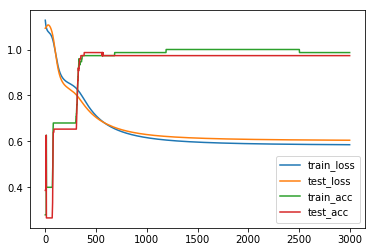

Done: 20/20


In [31]:
eigens_for_rate = {rate: experiment_for_rate(rate, epochs = 3000) for rate in learning_rates}

1.4262876e-06 0.2
1.2696701e-06 0.3
7.7104437e-07 0.4
1.1779134e-06 0.5
9.34483e-07 0.6


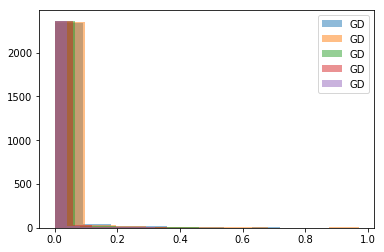

In [32]:
for r in learning_rates:
    print(np.median(eigens_for_rate[r]), r)
    hist_th(eigens_for_rate[r], threshold = 1, name = 'GD')
    plt.legend()
    #plt.show()

Bigger learning rate results in smaller eigenvalues (more sharp minima)?